20-1. 들어가며
2014년 GAN(Generative Adversarial Networks)이 세상에 나타난 이후, Computer Vision 및 다양한 분야에서 많은 관심을 받아 활발하게 응용되면서 빠르게 발전해왔습니다.
오늘은 이미지 생성 모델로 사용되는 일반적인 GAN에 조건을 부여하여 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 하는 방법에 대해 알아보겠습니다.

오늘 진행할 내용에는 Tensorflow로 신경망을 구현하는 과정을 보고 이해하는 부분이 많습니다.
아래 학습 전제를 읽어보시고 조금 부족한 부분이 있다면, 오늘 학습을 진행하면서 관련된 이전 학습 노드를 함께 참고하시길 바랍니다.

학습 전제
신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.
CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.
Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로 알고 있어야 합니다.
Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.
(중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해보려는 의지가 필요합니다.
학습 목표
조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
CNN 기반의 모델을 구현하는데 자신감을 갖습니다.
목차
조건 없는 생성모델(Unconditional Generative Model), GAN
조건 있는 생성모델(Conditional Generative Model), cGAN
내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
GAN의 입력에 이미지를 넣는다면? Pix2Pix
난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기
난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기
난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기
난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기
프로젝트 : Segmentation map으로 도로 이미지 만들기

20-2. 조건 없는 생성모델(Unconditional Generative Model), GAN
GAN을 이용해 MNIST, CIFAR-10 등의 데이터셋을 학습하고 생성해 보신 적 있으신가요?
성공적으로 학습되었다면, 아래와 같이 학습에 사용한 실제 손글씨 이미지와 매우 유사한 손글씨 이미지를 생성했을 것입니다.

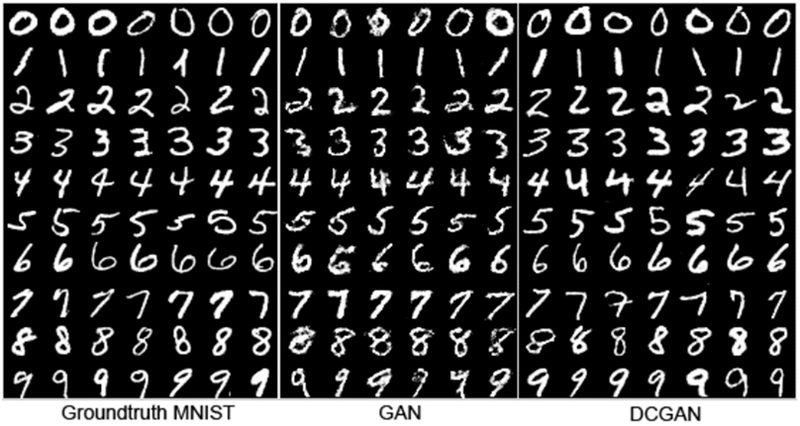
https://arxiv.org/pdf/1511.06434.pdf
여기서 한 가지 생각해봅시다!

예를 들어, 여러분이 "7"이라는 이미지를 만들고자 MNIST 데이터셋을 이용해 GAN을 열심히 학습시켰습니다.
학습이 완료된 모델을 이용해 "7"이라 쓰여있는 이미지를 얻기 위해 어떤 방법을 이용해야 할까요?🤔
여기서 할 수 있는 방법으로는 그저 다양한 노이즈를 계속 입력으로 넣어보고 "7"이라는 숫자 이미지가 생성되길 기다리는 것이죠.
운이 좋다면 한 방(?)에 만들 수 있겠지만 운이 없다면 100개가 넘는 이미지를 생성해도 7이 나오지 않을 수 있습니다. (생각보다 가능성이 적지 않습니다😩)
또한 혹시라도 "7" 이미지를 수만 개 만들어야 한다면, 새로운 노이즈 입력을 몇 번이나 넣어야 할지 상상만 해도 끔찍하네요…🤮

이렇듯 잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 조금 답답한 점이 하나 있다면, 바로 내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것입니다.
다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었습니다.

우리가 원하는 이미지를 바로바로 생성해 내기 위해서는 어떤 방법을 이용해야 할까요? GAN이라는 생성모델에 내가 원하는 이미지를 만들기 위한 특정 조건을 줄 수는 없을까요?
기약 없이 "7"이라 쓰인 이미지가 생성되길 기다릴 순 없으니까요.

20-3. 조건 있는 생성모델(Conditional Generative Model), cGAN
Conditional Generative Adversarial Nets (cGAN)은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법입니다.
여러분이 GAN을 잘 이해하고 있다면 이 방법(cGAN)은 전혀 어렵지 않습니다.

GAN의 목적 함수
먼저 GAN에 대해 간단히 복습해봅시다. GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전합니다. 이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습합니다.



  	 
$$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$$



위 식에서 는 임의 노이즈를, 와 는 각각 Discriminator 및 Generator를 의미합니다.

먼저 의 입장에서 식을 바라봅시다.
실제 이미지를 1, 가짜 이미지를 0으로 두었을 때, 는 이 식을 최대화해야 하며, 우변의 + 를 기준으로 양쪽의 항 및 이 모두 최대가 되게 해야 합니다.
이를 위해서 두 개의 log가 1이 되게 해야 합니다.
는 1이 되도록, 는 0이 되도록 해야 합니다.
다시 말하면, 진짜 데이터()를 진짜로, 가짜 데이터()를 가짜로 정확히 예측하도록 학습한다는 뜻입니다.

이번엔 의 입장에서 식을 바라봅시다. 와 반대로 는 위 식을 최소화해야 하고 위 수식에서는 마지막 항 만을 최소화하면 됩니다 (우변의 첫 번째 항은 와 관련이 없습니다).
이를 최소화한다는 것은 log 내부가 0이 되도록 해야함을 뜻하며, 가 1이 되도록 한다는 말과 같습니다.
즉, 는 를 입력받아 생성한 데이터 를 가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습한다는 뜻입니다.

cGAN의 목적 함수
GAN과 비교하며 알아볼 cGAN의 목적함수는 아래와 같습니다.

$$\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x\lvert{y})] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z\lvert{y})))]$$
  	 
GAN과 cGAN의 목적함수를 자세히 비교해 보시고 아래 퀴즈를 풀어봅시다.

Q1. cGAN의 목적함수는 GAN의 목적함수와 비교하여 어떤 부분이 바뀌었나요?

예시답안
D(x)와 G(z)가 각각 D(x∣y), G(z∣y)로 바뀌었습니다.

위에서 GAN의 목적함수를 이해했고, GAN의 목적함수와 비교해 위 식에서 달라진 부분을 잘 찾아내셨다면 크게 어렵지 않습니다.
위 식에서 바뀐 부분은 우변의 + 를 기준으로 양쪽 항에 가 추가되었다는 것뿐입니다.
와 의 입력에 특정 조건을 나타내는 정보인 를 같이 입력한다는 것이죠.
이외에는 GAN의 목적함수와 동일하므로 각각 를 추가로 입력받아 의 입장에서 식을 최소화하고, 의 입장에서 식을 최대화하도록 학습합니다.

여기서 함께 입력하는 는 어떠한 정보여도 상관없으며, MNIST 데이터셋을 학습시키는 경우 는 0~9 까지의 label 정보가 됩니다.
Generator가 어떠한 노이즈 를 입력받았을 때, 특정 조건 가 함께 입력되기 때문에, 를 통해 를 어떠한 이미지로 만들어야 할지에 대한 방향을 제어할 수 있게 됩니다.
조금 다르게 표현하면 가 임의 노이즈 입력인 의 가이드라고 할 수 있겠죠.

그림으로 이해하기
이번에는 GAN과 cGAN의 Feed forward 과정을 그림으로 비교해서 봅시다.

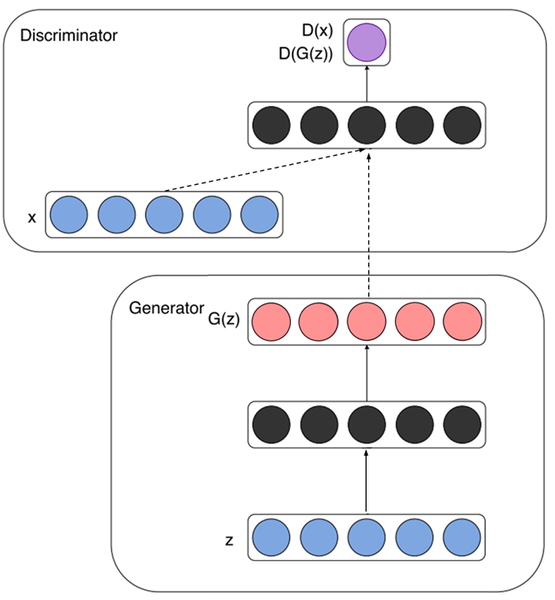

GAN의 학습 과정은 위 그림과 같습니다.

Generator
노이즈 (파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터  (빨간색)를 생성해 냅니다.
Discriminator
실제 데이터 와 Generator가 생성한 가짜 데이터 를 각각 입력받아  및  (보라색)를 계산하여 진짜와 가짜를 식별해 냅니다.

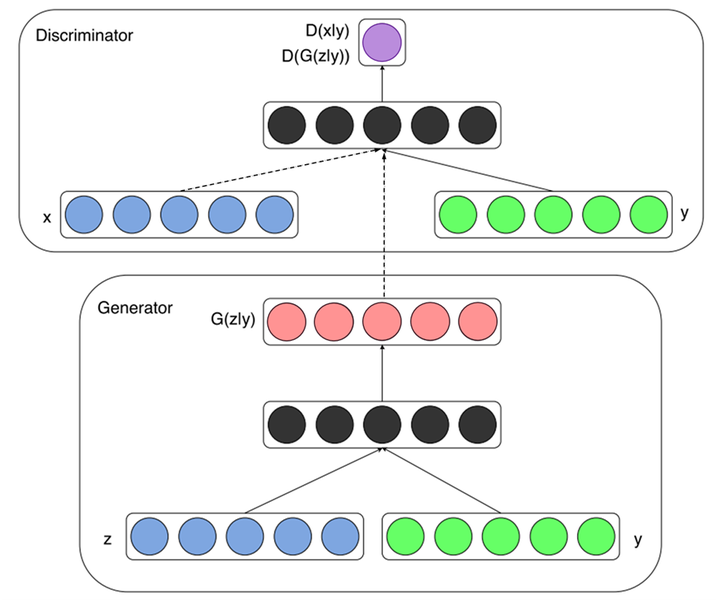

이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 라는 정보가 함께 입력된다는 것입니다.

Generator 노이즈 (파란색)와 추가 정보 (녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.
Discriminator 실제 데이터 와 Generator가 생성한 가짜 데이터 를 각각 입력받으며, 마찬가지로 정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 와 는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 와 Discriminator에 입력되는 는 동일한 레이블을 나타내야 합니다.
위 내용에 큰 어려움이 없었다면 cGAN에 대해 어느 정도 이해하셨을 것으로 예상됩니다. 다음 단계부터 GAN과 cGAN을 간단하게 구현하고 비교하면서 지금까지 내용에서 세부적으로 이해되지 않았던 부분을 채워봅시다.

20-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
이제부터는 앞에서 계속 비교해온 GAN과 cGAN을 각각 간단하게 구현하고 실험해보겠습니다.
간단한 실험을 위해 MNIST 데이터셋을 이용합니다. 실습 코드는 아래를 참고하여 작성했습니다.

참고 :TF2-GAN
데이터 준비하기
tensorflow-datasets 라이브러리가 설치되어 있지 않다면, 터미널을 열어 아래와 같이 라이브러리를 설치해 주세요.


```
# 코드로 형식 지정됨
$ pip install tensorflow-datasets

```


tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해봅시다.

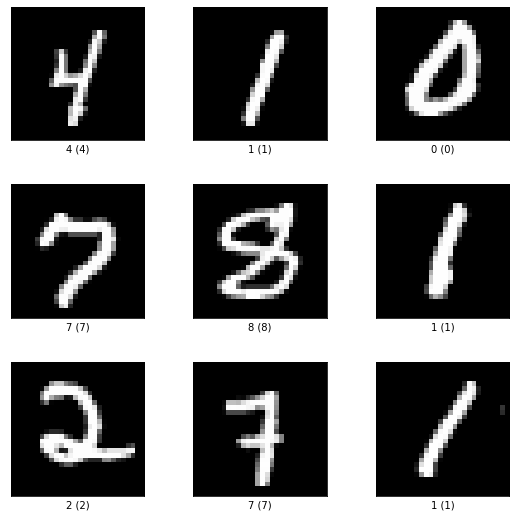

In [ ]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것입니다. 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의합니다. 이미지 픽셀값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했습니다.
GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성해 놓았습니다.

In [ ]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해봅시다. 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 합니다.



Label : tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


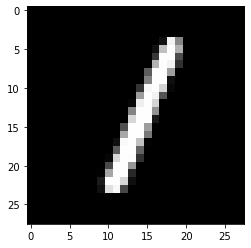

In [ ]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인하고싶지만, 보는 법을 모르시겠다구요? 0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있습니다. MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가집니다. 이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해 봅니다

GAN Generator 구성하기
이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행합니다. 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있습니다.
먼저 GAN의 Generator를 아래와 같이 구현합니다.

In [ ]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


__init__() 메서드 안에서 사용할 모든 레이어를 정의했습니다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인됩니다.
call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과합니다.
Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환됩니다.

cGAN Generator 구성하기
이번에는 cGAN의 Generator를 살펴봅시다.

In [ ]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


GAN의 Generator보다 구현이 복잡한듯 하지만 ,이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐입니다. 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해봅시다.
cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해주세요. (이전 GAN코드와 비교하여 잘 생각해 봅시다)

Q2. 위 코드로 생성한 모델에 대해 입력부터 출력까지 어떤 연산이 이루어지는지 설명해주세요.(init() 메서드에서는 노이즈 및 레이블 입력 각각에 적용할 레이어를 생성했습니다)

20-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
GAN Discriminator 구성하기
이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했습니다. 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠습니다.

먼저 GAN의 Discriminator를 아래와 같이 구현합니다.

In [ ]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


cGAN Discriminator 구성하기
다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용됩니다. Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 합니다. 만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같습니다.

$$max(w_1^Tx+b_1,\ w_2^Tx+b_2)$$

Maxout에 대한 자세한 정보는 아래 출처에서 확인할 수 있습니다.

[[라온피플] Stochastic Pooling & Maxout ](https://m.blog.naver.com/PostView.nhn?blogId=laonple&logNo=221259325819&proxyReferer=&proxyReferer=https:%2F%2Fwww.google.com%2F)

[[Paper] Maxout Networks](https://arxiv.org/pdf/1302.4389.pdf)

아래 코드와 같이 Maxout을 구성할 수 있습니다.
tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의했습니다.
이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성합니다.

In [ ]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력합니다. 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력됩니다. 식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원 입니다)

$$max(w_1^Tx+b_1,\ w_2^Tx+b_2, \ …, \ w_9^Tx+b_9,\ w_{10}^Tx+b_{10})$$

위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있습니다.

In [ ]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용됩니다. 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과합니다. 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.

Q3. 만약 위와 같은 cGAN의 Disciminator에 (28,28,1) 크기 이미지 및 (10,) 크기 레이블이 입력될 때, 연산의 순서를 다음과 같이 나타낼 수 있습니다.  



이미지가 Maxout 레이어를 통과

레이블이 Maxout 레이어를 통과

1)과 2)결과로 나온 representation을 결합(concate) 후 Maxout 레이어를 통과


위 3개 과정의 각 결과 차원 수는 각각 몇일까요?

예시답안
240, 50, 240

20-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해봅시다.
우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의합니다.
진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠습니다.

In [ ]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


GAN으로 MNIST 학습하기
이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용합니다.
여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했습니다.

In [ ]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보겠습니다. 100번의 반복마다 각 손실(loss)을 출력하도록 했습니다.

In [ ]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.2075178623199463, D:0.13265164196491241
[1/10 EPOCHS, 200 ITER] G:2.3831968307495117, D:0.11017870157957077
[1/10 EPOCHS, 300 ITER] G:2.424057960510254, D:0.13887092471122742
[1/10 EPOCHS, 400 ITER] G:3.037663221359253, D:0.09746907651424408
[2/10 EPOCHS, 100 ITER] G:3.030708074569702, D:0.22797894477844238
[2/10 EPOCHS, 200 ITER] G:2.8772757053375244, D:0.1967049539089203
[2/10 EPOCHS, 300 ITER] G:3.711817502975464, D:0.13068518042564392
[2/10 EPOCHS, 400 ITER] G:4.1256279945373535, D:0.1566569209098816
[3/10 EPOCHS, 100 ITER] G:3.69010066986084, D:0.17445336282253265
[3/10 EPOCHS, 200 ITER] G:3.1954307556152344, D:0.14409640431404114
[3/10 EPOCHS, 300 ITER] G:4.094927787780762, D:0.05689644813537598
[3/10 EPOCHS, 400 ITER] G:5.339282989501953, D:0.10150191187858582
[4/10 EPOCHS, 100 ITER] G:3.0336203575134277, D:0.1449558138847351
[4/10 EPOCHS, 200 ITER] G:2.6744701862335205, D:0.2507016658782959
[4/10 EPOCHS, 300 ITER] G:4.365802764892578, D:0.09042692184

짧은 시간 학습된 모델을 테스트해 봅시다. 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화합니다.
경고메시지가 출력된다면 그냥 무시하셔도 됩니다.

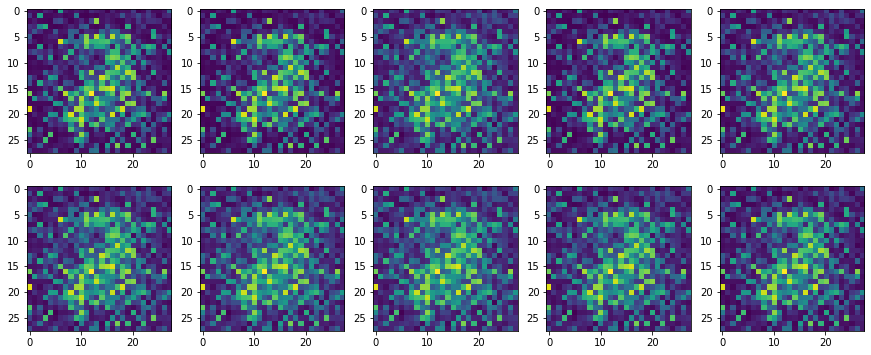

In [ ]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 봅니다.
위 구현을 그대로 500 epoch 학습한 가중치를 아래에 첨부했으니 한번 사용해 봅시다.

첨부된 파일(GAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성해 주세요.

In [ ]:
import os
# weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

weight_path = '/content/drive/MyDrive/DL_Study/AIFFEL/cGAN'
noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
# gan_generator.built = True
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

ValueError: ignored

위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었을 것입니다 (아닐 수도 있습니다).
이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있습니다. 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 봅시다.

cGAN으로 MNIST 학습하기
이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용합니다.
위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보겠습니다.

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없습니다.
위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 합니다.
뒤에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 아래에 첨부했습니다.

첨부된 파일(CGAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성해 주세요.

